In [ ]:
!pip install kaggle
!kaggle
with open("/root/.kaggle/kaggle.json","w") as fp:
  info = '{"username":"shashankmanurao","key":"52eb38fb5caedc18eda01c110d1022db"}'
  fp.write(info)
!kaggle competitions download -c m5-forecasting-accuracy                           

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python2.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 146, in authenticate
    self.config_file, self.config_dir))
IOError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.
 35% 5.00M/14.2M [00:00<00:00, 10.5MB/s]
100% 14.2M/14.2M [00:00<00:00, 26.4MB/s]
  0% 0.00/163k [00:00<?, ?B/s]
100% 163k/163k [00:00<00:00, 145MB/s]
 58% 9.00M/15.5M [00:00<00:00, 24.2MB/s]
100% 15.5M/15.5M [00:00<00:00, 35.0MB/s]
  0% 0.00/101k [00:00<?, ?B/s]
100% 101k/101k [00:00<00:00, 33.1MB/s]


In [ ]:
!unzip sell_prices.csv.zip
!unzip sales_train_validation.csv.zip

Archive:  sell_prices.csv.zip
  inflating: sell_prices.csv         
Archive:  sales_train_validation.csv.zip
  inflating: sales_train_validation.csv  


In [ ]:
import os
import gc
import time
import math
import datetime
from math import log, floor
from sklearn.neighbors import KDTree

import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.utils import shuffle
from tqdm.notebook import tqdm as tqdm

import seaborn as sns
from matplotlib import colors
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

import pywt
from statsmodels.robust import mad

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import scipy
import statsmodels
from scipy import signal
import statsmodels.api as sm
from fbprophet import Prophet
from scipy.signal import butter, deconvolve
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

import warnings
warnings.filterwarnings("ignore")


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
sales=pd.read_csv('sales_train_validation.csv')
calendar=pd.read_csv('calendar.csv')
prices=pd.read_csv('sell_prices.csv')

##Exploratory Data Analysis

Text(0.5, 1.0, 'Count of different categories')

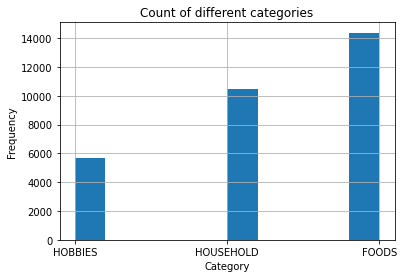

In [ ]:
sales['cat_id'].hist()
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.title('Count of different categories')

Text(0.5, 1.0, 'Count of different departments')

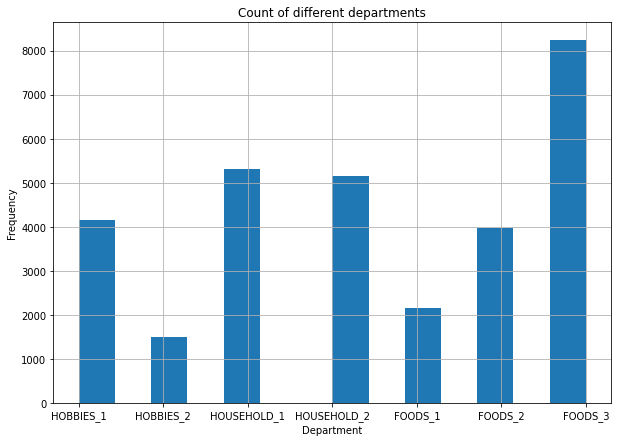

In [ ]:
 fig = plt.figure(figsize = (10,7))
ax = fig.gca()
sales['dept_id'].hist(ax = ax,bins=14)
plt.xlabel('Department')
plt.ylabel('Frequency')
plt.title('Count of different departments')

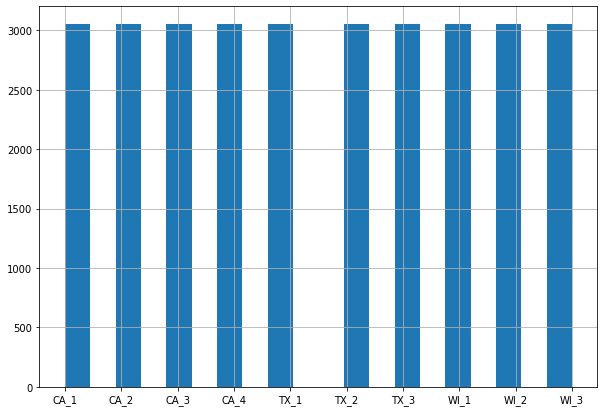

In [ ]:
fig = plt.figure(figsize = (10,7))
ax = fig.gca()
sales['store_id'].hist(ax=ax,bins=20)

In [ ]:
prices.head()

store_id        item_id  wm_yr_wk  sell_price
0     CA_1  HOBBIES_1_001     11325        9.58
1     CA_1  HOBBIES_1_001     11326        9.58
2     CA_1  HOBBIES_1_001     11327        8.26
3     CA_1  HOBBIES_1_001     11328        8.26
4     CA_1  HOBBIES_1_001     11329        8.26

In [ ]:
calender.head()

date  wm_yr_wk    weekday  ...  snap_CA  snap_TX  snap_WI
0  2011-01-29     11101   Saturday  ...        0        0        0
1  2011-01-30     11101     Sunday  ...        0        0        0
2  2011-01-31     11101     Monday  ...        0        0        0
3  2011-02-01     11101    Tuesday  ...        1        1        0
4  2011-02-02     11101  Wednesday  ...        1        0        1

[5 rows x 14 columns]

In [ ]:
calender.shape

(1969, 14)

In [ ]:
calendar['date']=pd.to_datetime(calendar['date'])

In [ ]:
calender.head()

date  wm_yr_wk    weekday  wday  ...  event_type_2  snap_CA snap_TX snap_WI
0 2011-01-29     11101   Saturday     1  ...           NaN        0       0       0
1 2011-01-30     11101     Sunday     2  ...           NaN        0       0       0
2 2011-01-31     11101     Monday     3  ...           NaN        0       0       0
3 2011-02-01     11101    Tuesday     4  ...           NaN        1       1       0
4 2011-02-02     11101  Wednesday     5  ...           NaN        1       0       1

[5 rows x 14 columns]

In [ ]:
sales.shape

(30490, 1919)

In [ ]:
ids = sorted(list(set(sales['id'])))

In [ ]:
d_cols = [c for c in sales.columns if 'd_' in c]

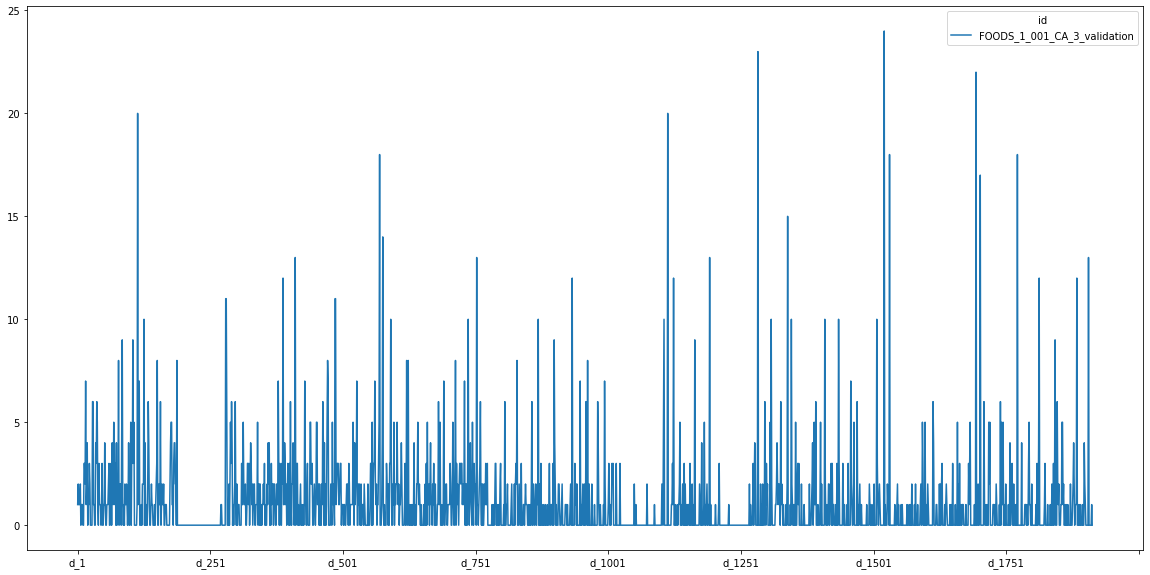

In [ ]:
x_1 = sales.loc[sales['id'] == ids[2]].set_index('id')[d_cols]
x_1.T.plot(figsize=(20,10))

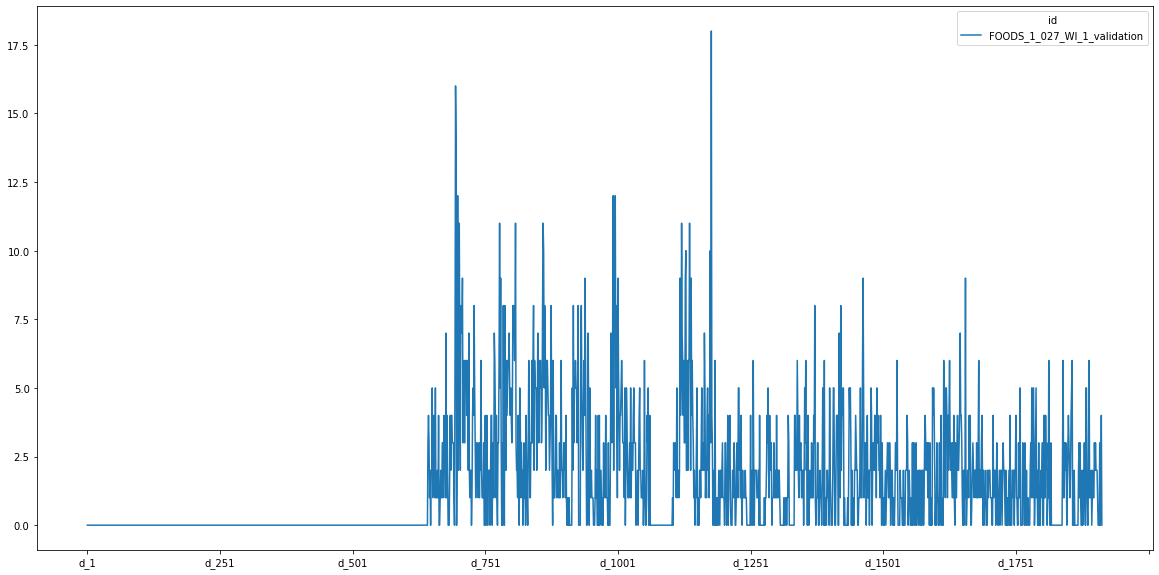

In [ ]:
x_2 = sales.loc[sales['id'] == ids[257]].set_index('id')[d_cols]
x_2.T.plot(figsize=(20,10))

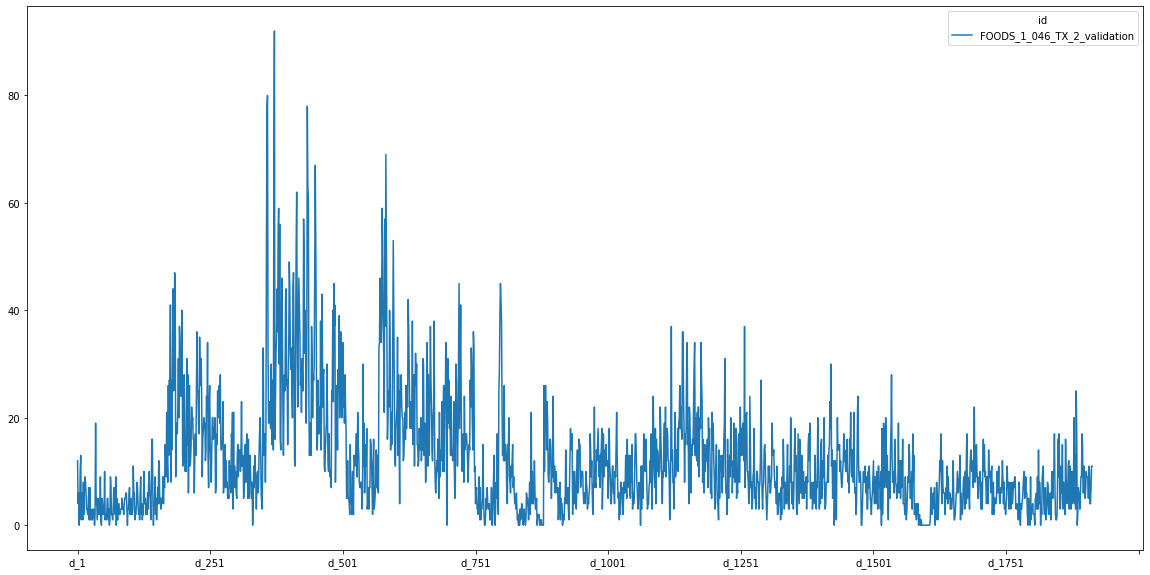

In [ ]:
x_3 = sales.loc[sales['id'] == ids[445]].set_index('id')[d_cols]
x_3.T.plot(figsize=(20,10))

In [ ]:
past_sales = sales.set_index('id')[d_cols].T.merge(calendar.set_index('d')['date'],
           left_index=True,
           right_index=True,
           validate='1:1').set_index('date')

In [ ]:
past_sales.head()

HOBBIES_1_001_CA_1_validation  ...  FOODS_3_827_WI_3_validation
date                                       ...                             
2011-01-29                              0  ...                            0
2011-01-30                              0  ...                            0
2011-01-31                              0  ...                            0
2011-02-01                              0  ...                            0
2011-02-02                              0  ...                            0

[5 rows x 30490 columns]

##Windowing Visualizations

In [ ]:
state_list = ['CA','WI','TX']
fig = go.Figure()
for state in state_list:
    state_items = [c for c in past_sales.columns if state in c]
    data = past_sales[state_items].sum(axis=1).rolling(90).mean()
    fig.add_trace(go.Scatter(x=np.arange(len(data)), y=data, name=state))
fig.update_layout(yaxis_title="Sales", xaxis_title="Time", title="Rolling Average Sales vs. Time (per state)")

In [ ]:
cali_list = ['CA_1','CA_2','CA_3','CA_4']
fig = go.Figure()
for cali in cali_list:
    cali_items = [c for c in past_sales.columns if cali in c]
    data = past_sales[cali_items].sum(axis=1).rolling(90).mean()
    fig.add_trace(go.Scatter(x=np.arange(len(data)), y=data, name=cali))
fig.update_layout(yaxis_title="Sales", xaxis_title="Time", title="Rolling Average Sales vs. Time (for california)")

In [ ]:
wis_list = ['WI_1','WI_2','WI_3']
fig = go.Figure()
for wis in wis_list:
    wis_items = [c for c in past_sales.columns if wis in c]
    data = past_sales[wis_items].sum(axis=1).rolling(90).mean()
    fig.add_trace(go.Scatter(x=np.arange(len(data)), y=data, name=wis))
fig.update_layout(yaxis_title="Sales", xaxis_title="Time", title="Rolling Average Sales vs. Time (for wisconsin)")

In [ ]:
texas_list = ['TX_1','TX_2','TX_3']
fig = go.Figure()
for texas in texas_list:
    texas_items = [c for c in past_sales.columns if texas in c]
    data = past_sales[texas_items].sum(axis=1).rolling(90).mean()
    fig.add_trace(go.Scatter(x=np.arange(len(data)), y=data, name=texas))
fig.update_layout(yaxis_title="Sales", xaxis_title="Time", title="Rolling Average Sales vs. Time (for texas)")

In [ ]:
cat_list = sales['cat_id'].unique()
fig = go.Figure()
for cat in cat_list:
    category_items = [c for c in past_sales.columns if cat in c]
    data = past_sales[category_items].sum(axis=1).rolling(90).mean()
    fig.add_trace(go.Scatter(x=np.arange(len(data)), y=data, name=cat))
fig.update_layout(yaxis_title="Sales", xaxis_title="Time", title="Rolling Average Sales vs. Time (per category)")

In [ ]:
dept_list = sales['dept_id'].unique()
fig = go.Figure()
for dept in dept_list:
    dept_items = [c for c in past_sales.columns if dept in c]
    data = past_sales[dept_items].sum(axis=1).rolling(90).mean()
    fig.add_trace(go.Scatter(x=np.arange(len(data)), y=data, name=dept))
fig.update_layout(yaxis_title="Sales", xaxis_title="Time", title="Rolling Average Sales vs. Time (per department)")

In [ ]:
items = [c for c in past_sales.columns]
data = pd.DataFrame(past_sales[items].sum(axis=1))
#.rolling(7,center=True).mean())
data.columns=['sales']
data.head()

sales
date             
2011-01-29  32631
2011-01-30  31749
2011-01-31  23783
2011-02-01  25412
2011-02-02  19146

In [ ]:
#data['sales'] = pd.DataFrame(past_sales[items].sum(axis=1))

In [ ]:
data.shape

(1913, 1)

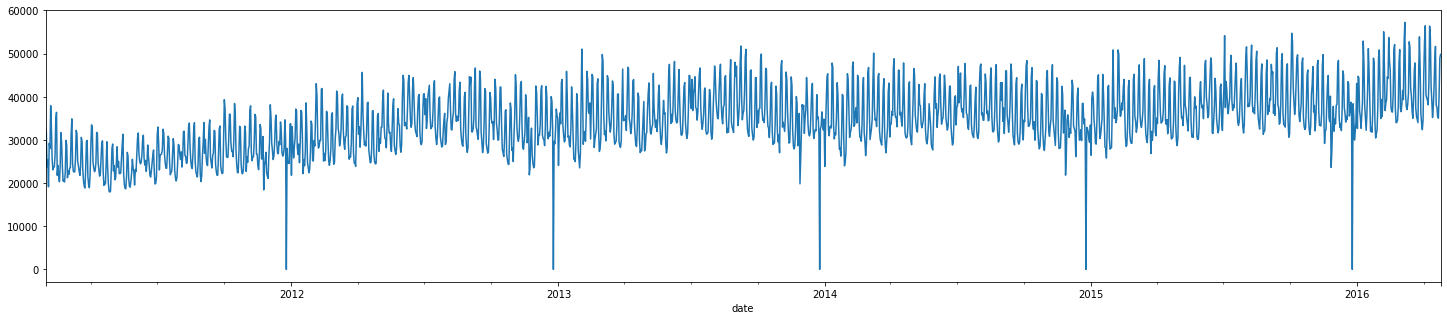

In [ ]:
data["sales"].plot(figsize=(25,5))

In [ ]:
data.shape

(1913, 1)

##Time Series components

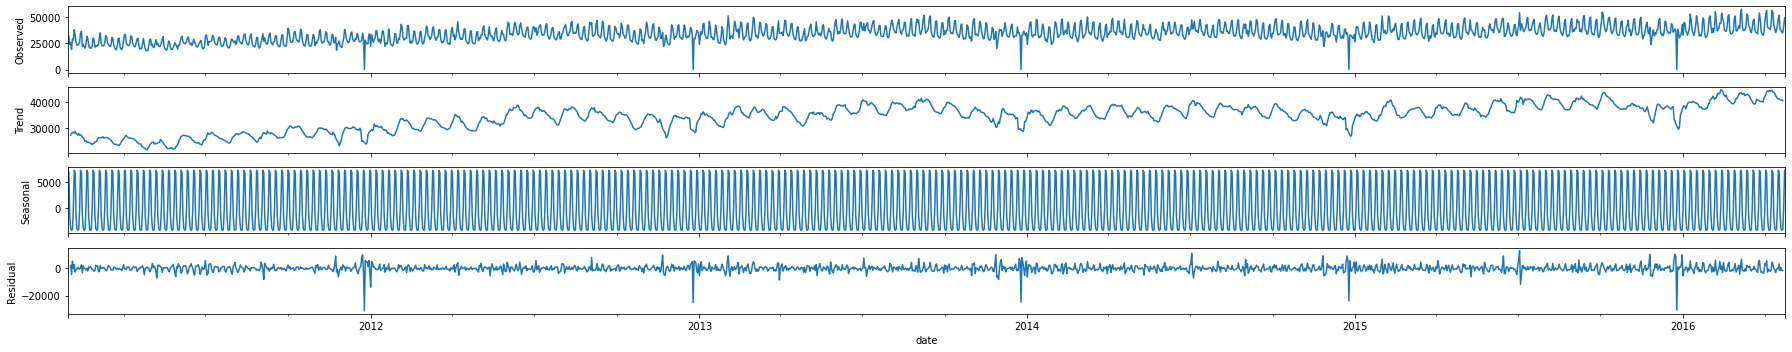

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 25, 5
decomposed_sales = sm.tsa.seasonal_decompose(data["sales"].dropna()) 
figure = decomposed_sales.plot()
plt.show()

##Augmented Dickey-Fuller Test

In [ ]:
adf=adfuller(data["sales"].dropna())
print('p-value: ',adf[1])

p-value:  0.5009604361797744


In [ ]:
data['First difference']=data["sales"]-data["sales"].shift(1)
adf1=adfuller(data["First difference"].dropna())
print('p-value(First difference): ',adf1[1])

p-value(First difference):  0.0


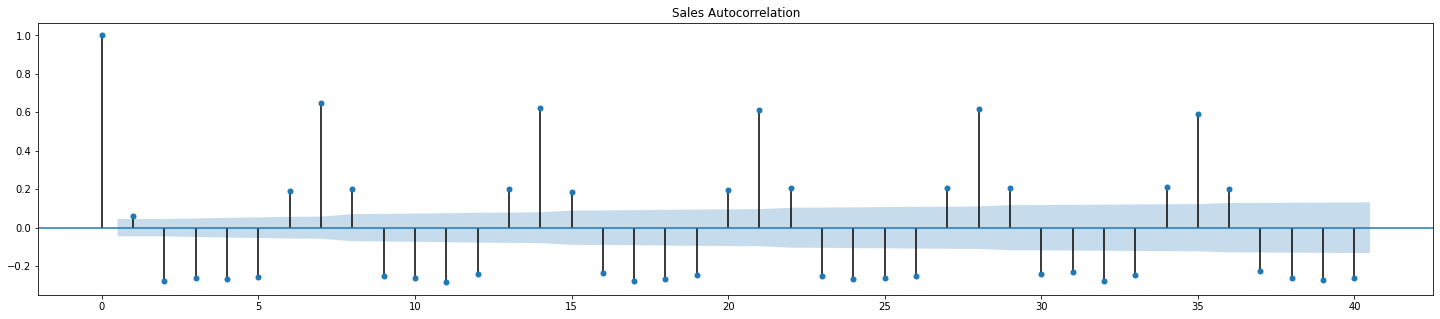

In [ ]:
plot_acf(data["First difference"].dropna(),lags=40,title="Sales Autocorrelation")
plt.show()

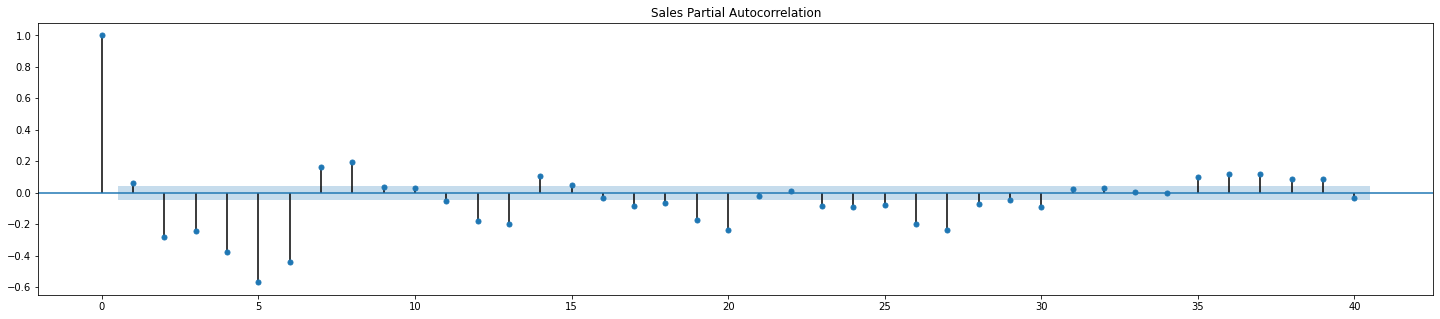

In [ ]:
plot_pacf(data["First difference"].dropna(),lags=40,title="Sales Partial Autocorrelation")
plt.show()

##ARIMA

In [ ]:
model=ARIMA(data['sales'].iloc[:1600],order=(1,1,1))

In [ ]:
arima_model=model.fit()

In [ ]:
data['forecast_ARIMA']= 0
data['forecast_ARIMA'] = arima_model.predict(start=1600,end=1912,dynamic=True)
#start=1500,end=1907,dynamic=True)

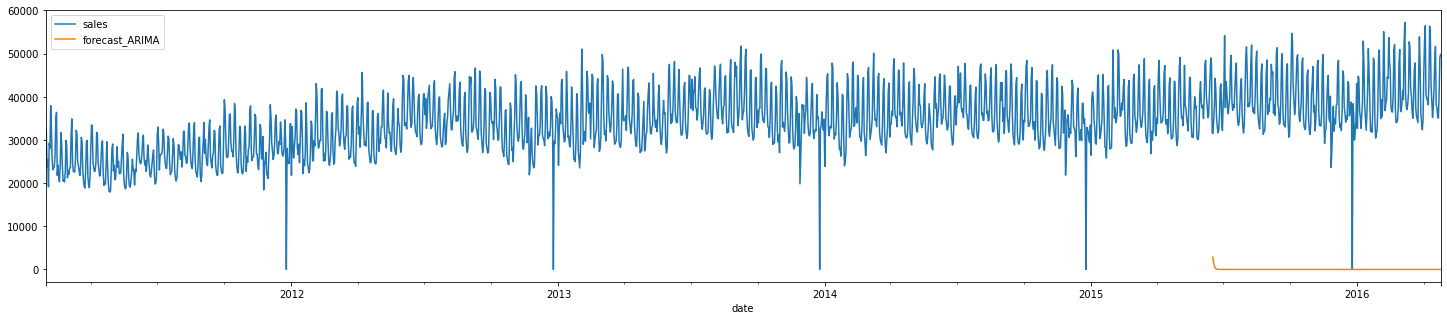

In [ ]:
data[['sales','forecast_ARIMA']].plot(figsize=(25,5))

In [ ]:
rmse = math.sqrt(mean_squared_error(data['sales'].iloc[1600:].values,data['forecast_ARIMA'].iloc[1600:].values))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 40243.58630679122.


##SARIMAX(Seasonal ARIMA)

In [ ]:
import statsmodels.api as sm

In [ ]:
import time
start = time.time()
model2=sm.tsa.statespace.SARIMAX(data['sales'].iloc[0:1600],order=(1,1,1),seasonal_order=(1,1,1,7))
#start_params = np.r_[[0] * (model2.k_params - 1), 1]
sarimax_model=model2.fit()
print(time.time() - start)

7.296466112136841


In [ ]:
data['forecast_SARIMAX']=0
data['forecast_SARIMAX']=sarimax_model.predict(start=1600,end=1912,dynamic=True)

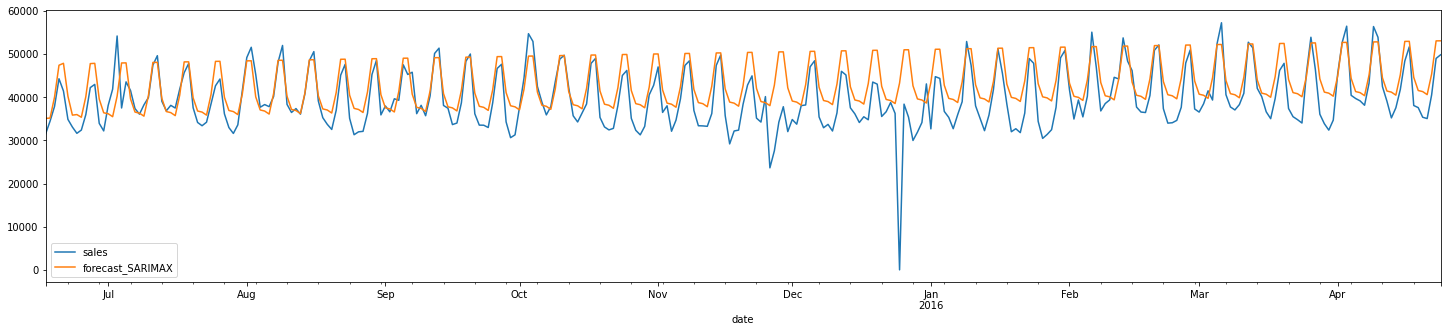

In [ ]:
data[['sales','forecast_SARIMAX']].iloc[1600:].plot(figsize=(25,5))

In [ ]:
rmse = math.sqrt(mean_squared_error(data['sales'].iloc[1600:].values,data['forecast_SARIMAX'].iloc[1600:].values))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 5437.713646508437.


##Hot Linear

In [ ]:
fit = Holt(data['sales'].iloc[:1600]).fit(smoothing_level = 0.25, smoothing_slope = 0.005)
predictions_holt=fit.forecast(313)

In [ ]:
data=data.drop('Hot_linear',axis=1)

In [ ]:
data=data.join(pd.DataFrame(predictions_holt).rename(columns={0:'Hot_linear'}))

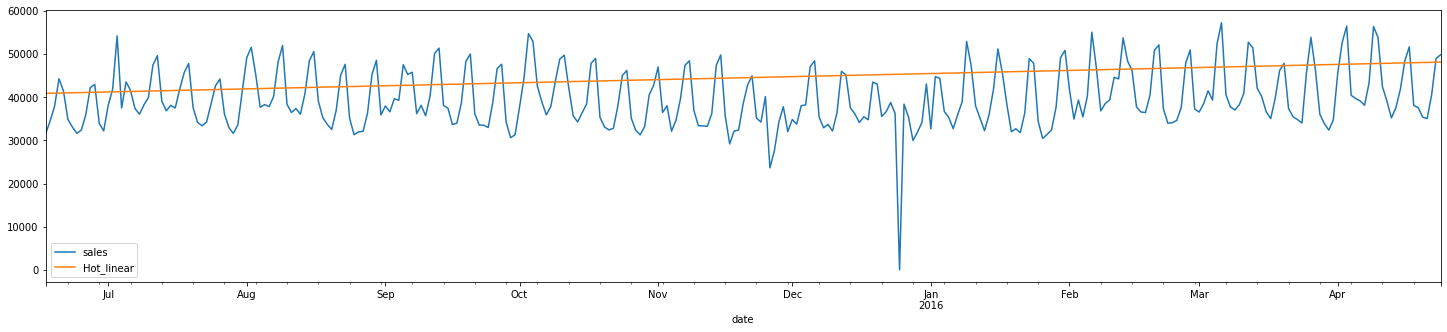

In [ ]:
data[['sales','Hot_linear']].iloc[1600:].plot(figsize=(25,5))

In [ ]:
rmse = math.sqrt(mean_squared_error(data['sales'].iloc[1600:].values,data['Hot_linear'].iloc[1600:].values))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 8385.99409673035.


##Exponential Smoothing

In [ ]:
fit = ExponentialSmoothing(data['sales'].iloc[:1600],seasonal_periods=7,trend='add',seasonal='add',damped=True).fit()
predictions_exps=fit.forecast(313)

In [ ]:
data=data.drop('Exponential_Smoothing',axis=1)

In [ ]:
data=data.join(pd.DataFrame(predictions_exps).rename(columns={0:'Exponential_Smoothing'}))

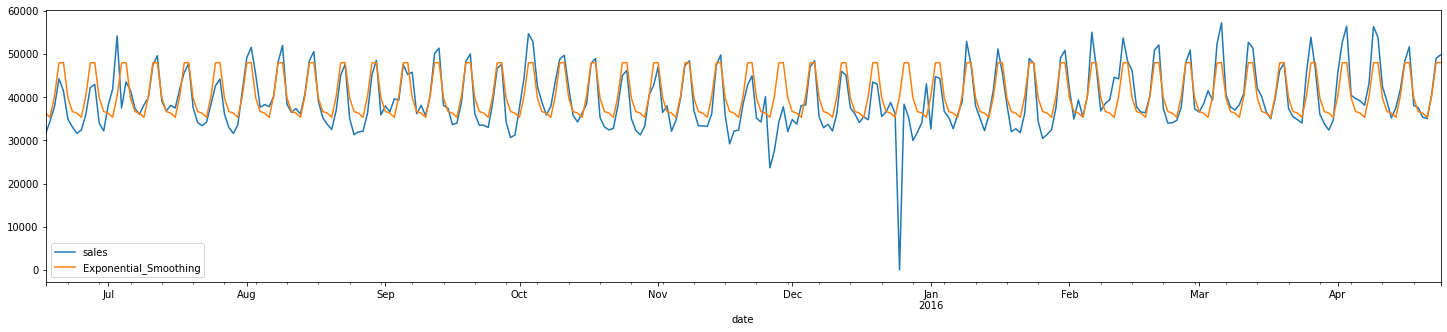

In [ ]:
data[['sales','Exponential_Smoothing']].iloc[1600:].plot(figsize=(25,5))

In [ ]:
rmse = math.sqrt(mean_squared_error(data['sales'].iloc[1600:].values,data['Exponential_Smoothing'].iloc[1600:].values))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 4411.411306520405.


In [ ]:
#i=1600
#predictions_exps=data['sales'].copy()
#predictions_exps.iloc[1601:]=0
#for k in range(313):
#  fit = ExponentialSmoothing(predictions_exps.iloc[:i], seasonal_periods=7).fit()
#  predictions_exps.iloc[i+1:]=fit.forecast(1)[0]
#  i+=1  

In [ ]:
#predictions_exps.iloc[:1601]=np.nan

In [ ]:
#data=data.drop('Exponential_Smoothing',axis=1)

In [ ]:
#data=data.join(pd.DataFrame(predictions_exps).rename(columns={'sales':'Exponential_Smoothing'}))

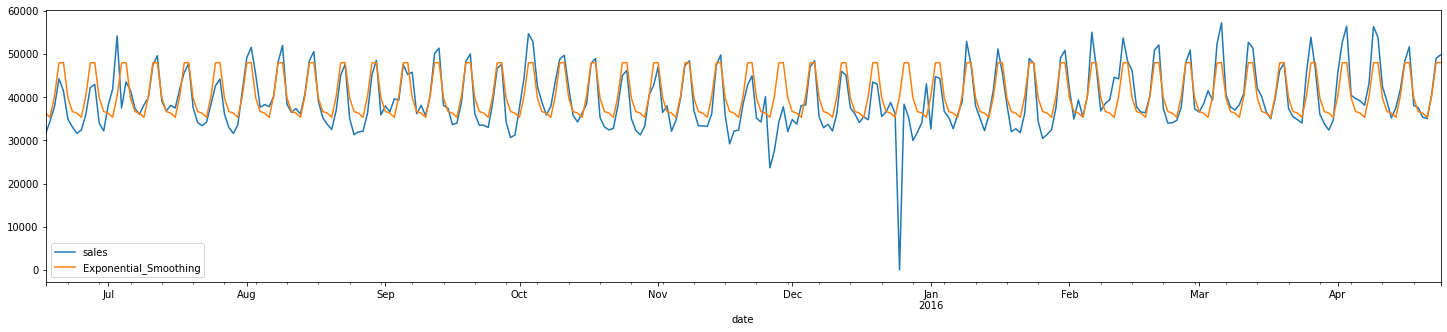

In [ ]:
#data[['sales','Exponential_Smoothing']].iloc[1600:].plot(figsize=(25,5))

##Prophet

In [ ]:
pred_prophet = data['sales'].iloc[:1600].copy()
pred_prophet=pred_prophet.reset_index()
pred_prophet.columns = ["ds", "y"]
model = Prophet(weekly_seasonality=True)
model.fit(pred_prophet)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
future = model.make_future_dataframe(periods=313)
forecast=model.predict(future)[['ds','yhat']]

In [ ]:
forecast=forecast.set_index('ds').rename(columns={'yhat':'prophet_raw'})

In [ ]:
forecast.iloc[:1600]=np.nan

In [ ]:
#data=data.drop('prophet_raw',axis=1)

In [ ]:
data=data.join(forecast)

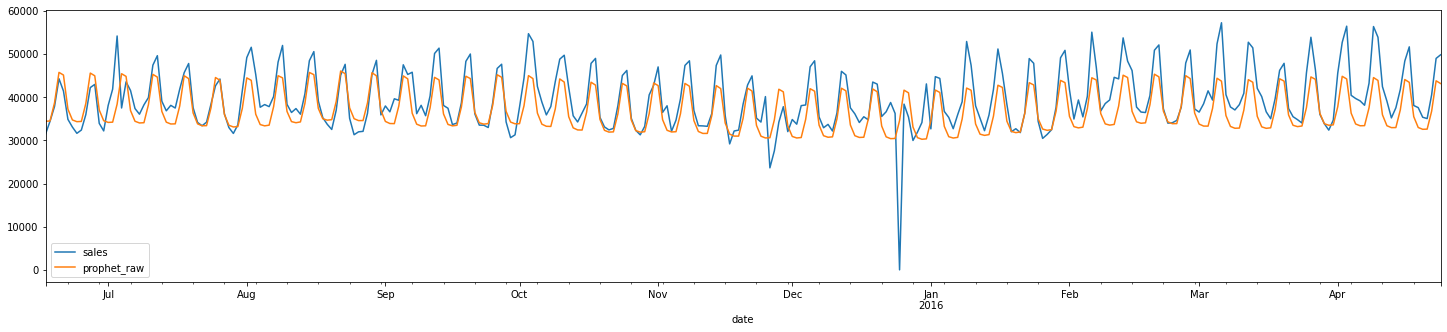

In [ ]:
data[['sales','prophet_raw']].iloc[1600:].plot(figsize=(25,5))

In [ ]:
rmse = math.sqrt(mean_squared_error(data['sales'].iloc[1600:].values,data['prophet_raw'].iloc[1600:].values))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 4960.608656112359.


In [ ]:
pred_prophet = data['First difference'].iloc[:1600].copy()
pred_prophet=pred_prophet.reset_index()
pred_prophet.columns = ["ds", "y"]
model = Prophet(weekly_seasonality=True)
model.fit(pred_prophet.dropna())

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
future = model.make_future_dataframe(periods=313)
forecast=model.predict(future)[['ds','yhat']]

In [ ]:
forecast=forecast.set_index('ds').rename(columns={'yhat':'prophet'})

In [ ]:
forecast.iloc[:1599]=np.nan

In [ ]:
data=data.drop('prophet',axis=1)

In [ ]:
data=data.join(forecast)

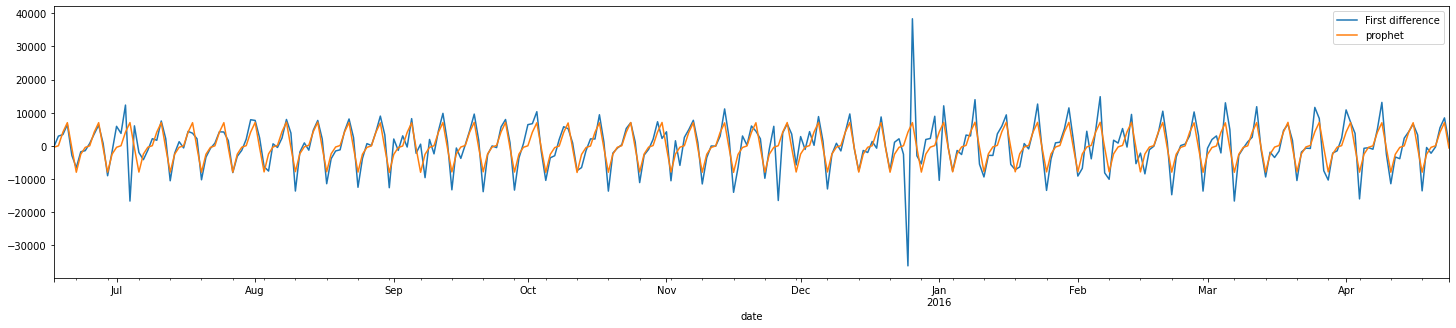

In [ ]:
data[['First difference','prophet']].iloc[1600:].plot(figsize=(25,5))

In [ ]:
rmse = math.sqrt(mean_squared_error(data['First difference'].iloc[1600:].values,data['prophet'].iloc[1600:].values))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 4610.345545297857.


In [ ]:
data['prophet'].iloc[1600:1601]=data['sales'].iloc[1599:1600].values+data['prophet'].iloc[1600:1601].values

In [ ]:
i=1600
for k in range(313):
  data['prophet'].iloc[i+1:i+2]=data['prophet'].iloc[i:i+1].values+data['prophet'].iloc[i+1:i+2].values
  i+=1

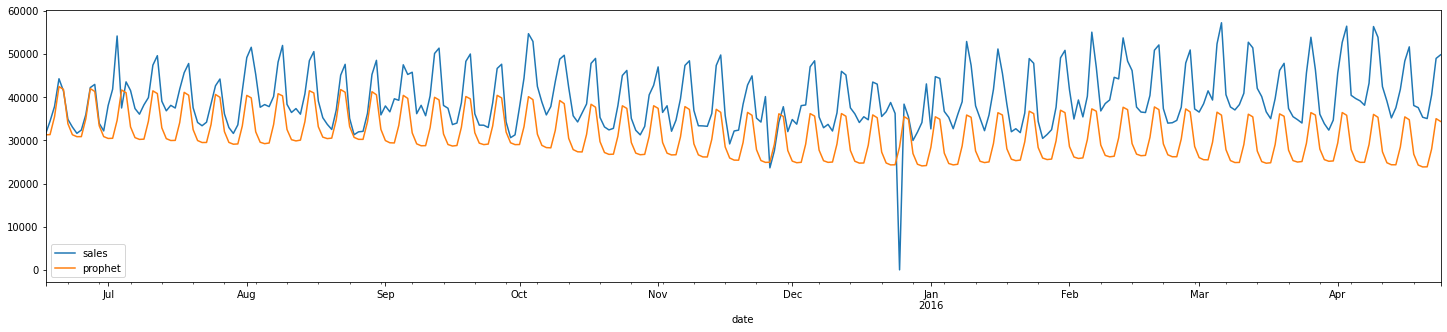

In [ ]:
data[['sales','prophet']].iloc[1600:].plot(figsize=(25,5))

In [ ]:
rmse = math.sqrt(mean_squared_error(data['sales'].iloc[1600:].values,data['prophet'].iloc[1600:].values))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 9799.069622137704.


##Unobserved Components Models(UCM)

In [ ]:
train_sample = data['First difference'].iloc[1:1600].values
model = sm.tsa.UnobservedComponents(train_sample,seasonal=7)
result = model.fit(maxiter=1000,disp=False)
predicted_result = result.predict(start=1600, end=1912)

In [ ]:
data['UCM']=0
data['UCM'].iloc[1600:]=predicted_result

In [ ]:
data['UCM'].iloc[1600:]

date
2015-06-17     409.0
2015-06-18    4697.0
2015-06-19    4571.0
2015-06-20    4128.0
2015-06-21   -1401.0
               ...  
2016-04-20     409.0
2016-04-21    4697.0
2016-04-22    4571.0
2016-04-23    4128.0
2016-04-24   -1401.0
Name: UCM, Length: 313, dtype: float64

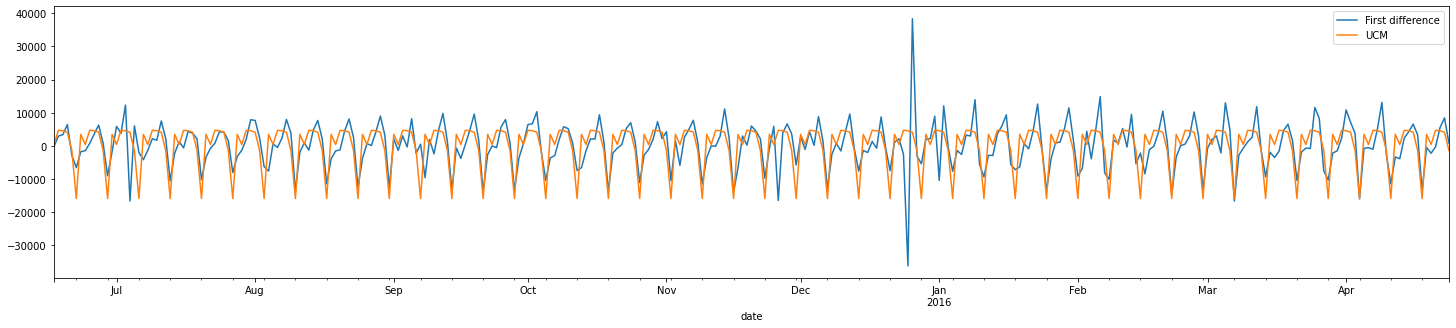

In [ ]:
data[['First difference','UCM']].iloc[1600:].plot(figsize=(25,5))

In [ ]:
rmse = math.sqrt(mean_squared_error(data['First difference'].iloc[1600:].values,data['UCM'].iloc[1600:].values))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 5991.664374048833.


In [ ]:
data['UCM'].iloc[1600:1601]=data['sales'].iloc[1599:1600].values+data['UCM'].iloc[1600:1601].values

In [ ]:
i=1600
for k in range(313):
  data['UCM'].iloc[i+1:i+2]=data['UCM'].iloc[i:i+1].values+data['UCM'].iloc[i+1:i+2].values
  i+=1

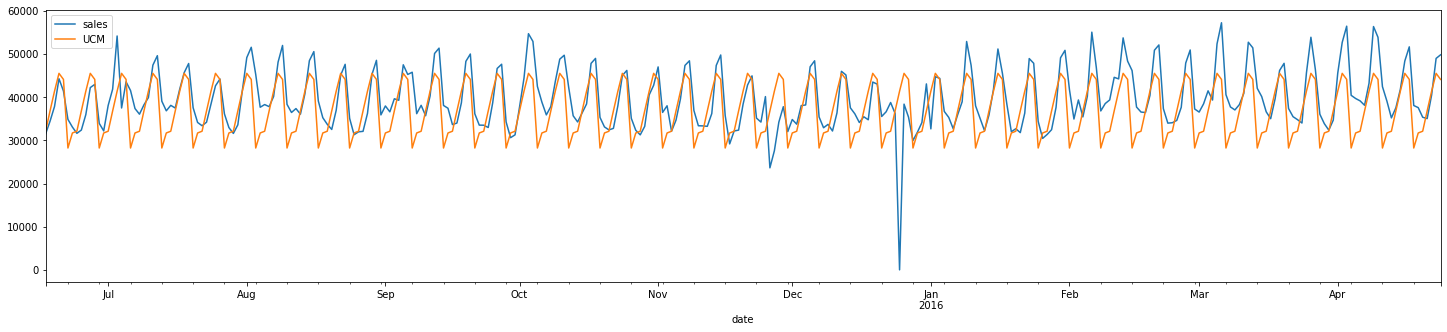

In [ ]:
data[['sales','UCM']].iloc[1600:].plot(figsize=(25,5))

In [ ]:
rmse = math.sqrt(mean_squared_error(data['sales'].iloc[1600:].values,data['UCM'].iloc[1600:].values))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 6140.098641640335.


##VARMAX

In [ ]:
state_list = ['CA','WI','TX']
state_items = [c for c in past_sales.columns if 'CA' in c]
cal = past_sales[state_items].sum(axis=1)
state_items = [c for c in past_sales.columns if 'TX' in c]
tex = past_sales[state_items].sum(axis=1)
state_items = [c for c in past_sales.columns if 'WI' in c]
wis = past_sales[state_items].sum(axis=1)

In [ ]:
train_sample = pd.concat([cal.diff().iloc[1:],tex.diff().iloc[1:],wis.diff().iloc[1:]],axis=1)
model = sm.tsa.VARMAX(train_sample.iloc[:1599],order=(1,1),trend='c')
result = model.fit(maxiter=1000,disp=False)
predicted_result = result.predict(start=1599, end=1911)

In [ ]:
print(result.summary())

                           Statespace Model Results                           
Dep. Variable:              [0, 1, 2]   No. Observations:                 1599
Model:                     VARMA(1,1)   Log Likelihood              -40736.661
                          + intercept   AIC                          81527.323
Date:                Mon, 25 May 2020   BIC                          81672.505
Time:                        03:28:21   HQIC                         81581.235
Sample:                    01-30-2011                                         
                         - 06-16-2015                                         
Covariance Type:                  opg                                         
Ljung-Box (Q):          3527.94, 165.84, 772.26   Jarque-Bera (JB):   1832.84, 2367.46, 350.25
Prob(Q):                       0.00, 0.00, 0.00   Prob(JB):                   0.00, 0.00, 0.00
Heteroskedasticity (H):        1.40, 1.40, 2.24   Skew:                     -0.32, 0.61, -0.04
Prob

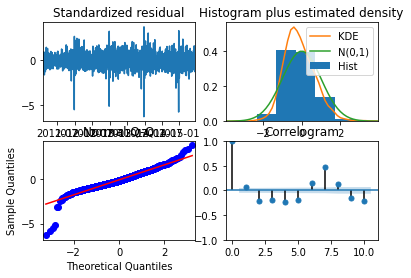

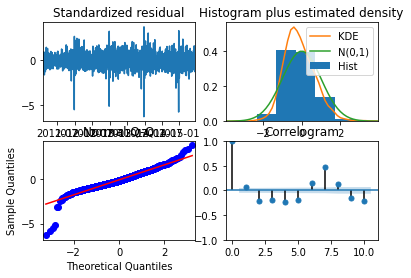

In [ ]:
result.plot_diagnostics()

In [ ]:
rmse = math.sqrt(mean_squared_error(train_sample.iloc[1599:].values, predicted_result.values))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 2549.7337221898106.


In [ ]:
train_sample=train_sample.rename(columns={0:'California',1:'Texas',2:'Wisconsin'})
predicted_result=predicted_result.rename(columns={0:'California_pred',1:'Texas_pred',2:'Wisconsin_pred'})

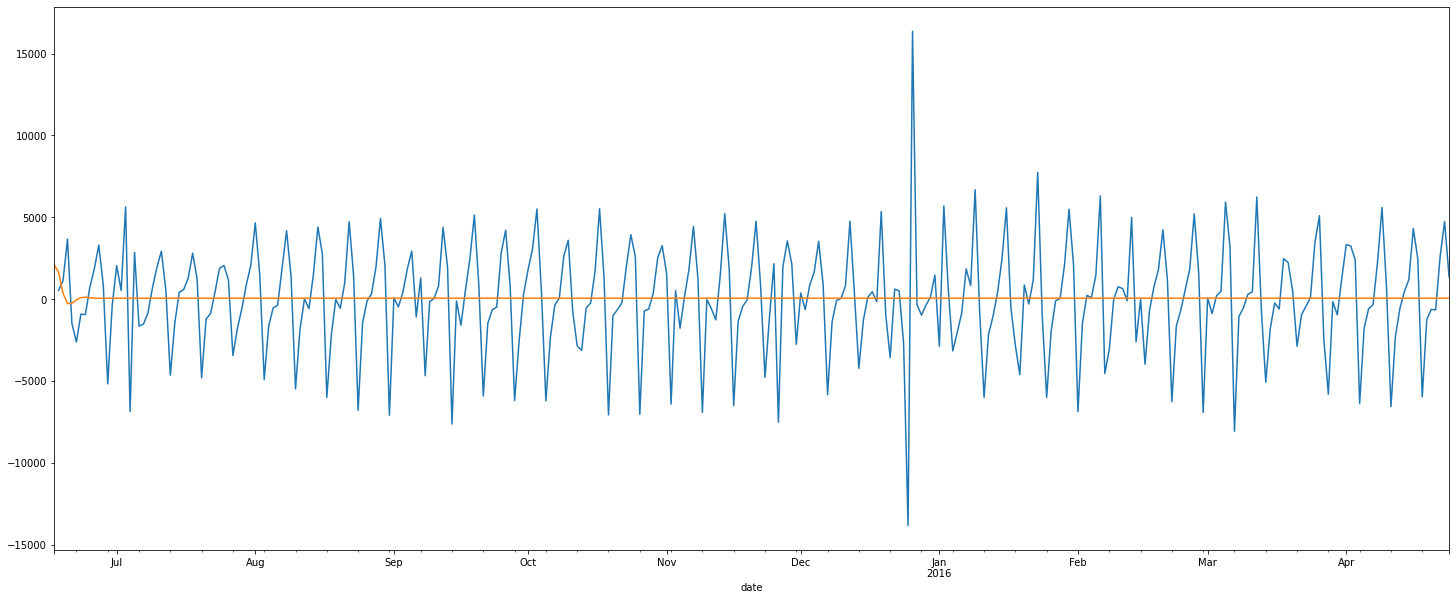

In [ ]:
train_sample['California'].iloc[1600:].plot(figsize=(25,10))
predicted_result['California_pred'].plot()

In [ ]:
predicted_result['California_pred'].iloc[0:1]=cal.iloc[1599:1600].values+predicted_result['California_pred'].iloc[0:1].values
predicted_result['Texas_pred'].iloc[0:1]=tex.iloc[1599:1600].values+predicted_result['Texas_pred'].iloc[0:1].values
predicted_result['Wisconsin_pred'].iloc[0:1]=wis.iloc[1599:1600].values+predicted_result['Wisconsin_pred'].iloc[0:1].values

In [ ]:
j=1
for k in range(313):
  predicted_result['California_pred'].iloc[j:j+1]=predicted_result['California_pred'].iloc[j-1:j].values+predicted_result['California_pred'].iloc[j:j+1].values
  predicted_result['Texas_pred'].iloc[j:j+1]=predicted_result['Texas_pred'].iloc[j-1:j].values+predicted_result['Texas_pred'].iloc[j:j+1].values
  predicted_result['Wisconsin_pred'].iloc[j:j+1]=predicted_result['Wisconsin_pred'].iloc[j-1:j].values+predicted_result['Wisconsin_pred'].iloc[j:j+1].values
  j+=1

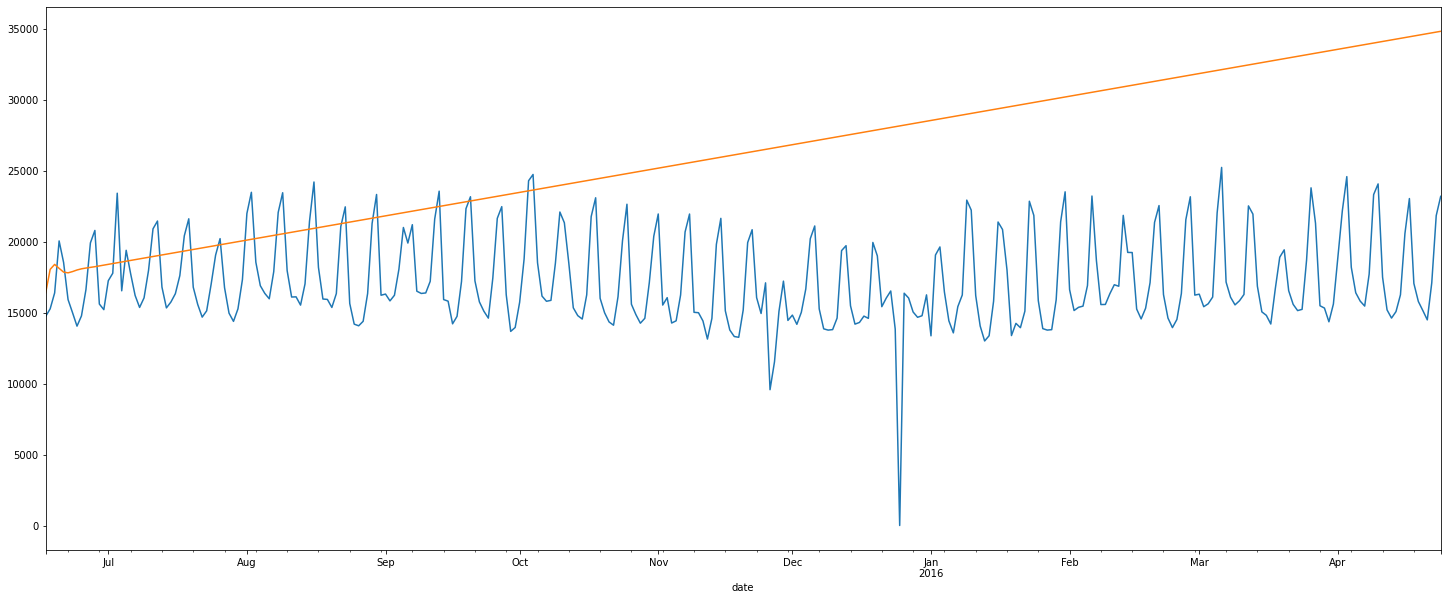

In [ ]:
cal.iloc[1600:].plot(figsize=(25,10))
predicted_result['California_pred'].plot()

##Dynamic Factor

In [ ]:
train_sample = pd.concat([cal.diff().iloc[1:],tex.diff().iloc[1:],wis.diff().iloc[1:]],axis=1)
model = sm.tsa.DynamicFactor(train_sample.iloc[:1599], k_factors=1, factor_order=1)
result = model.fit(maxiter=1000,disp=False)
predicted_result = result.predict(start=1599, end=1911)

In [ ]:
print(result.summary())

                                   Statespace Model Results                                  
Dep. Variable:                             [0, 1, 2]   No. Observations:                 1599
Model:             DynamicFactor(factors=1, order=1)   Log Likelihood              -46964.546
Date:                               Sun, 24 May 2020   AIC                          93943.093
Time:                                       18:20:44   BIC                          93980.733
Sample:                                   01-30-2011   HQIC                         93957.070
                                        - 06-16-2015                                         
Covariance Type:                                 opg                                         
Ljung-Box (Q):          6748.69, 583.29, 1519.02   Jarque-Bera (JB):   627.68, 4267.10, 1051.85
Prob(Q):                        0.00, 0.00, 0.00   Prob(JB):                   0.00, 0.00, 0.00
Heteroskedasticity (H):         1.48, 1.85, 1.91   Skew:

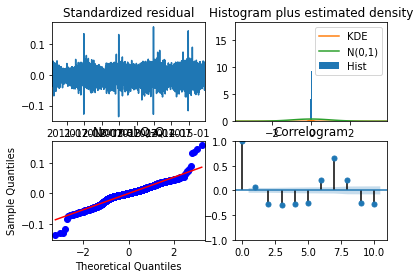

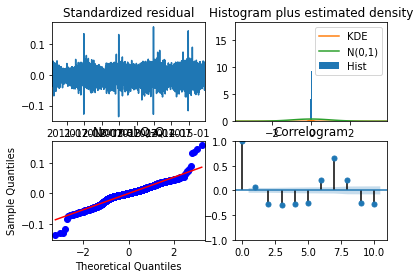

In [ ]:
result.plot_diagnostics()

In [ ]:
rmse = math.sqrt(mean_squared_error(train_sample.iloc[1599:].values, predicted_result.values))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 2544.3293895988268.


In [ ]:
train_sample=train_sample.rename(columns={0:'California',1:'Texas',2:'Wisconsin'})
predicted_result=predicted_result.rename(columns={0:'California_pred',1:'Texas_pred',2:'Wisconsin_pred'})

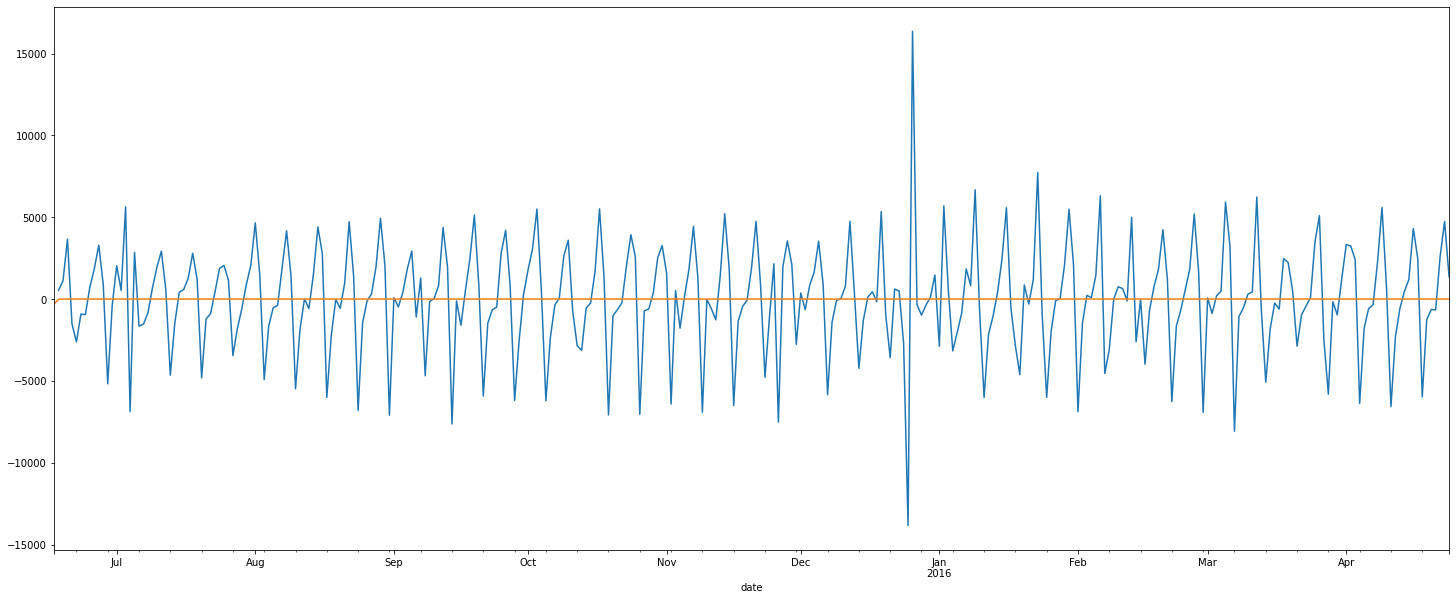

In [ ]:
train_sample['California'].iloc[1600:].plot(figsize=(25,10))
predicted_result['California_pred'].plot()

In [ ]:
predicted_result['California_pred'].iloc[0:1]=cal.iloc[1599:1600].values+predicted_result['California_pred'].iloc[0:1].values
predicted_result['Texas_pred'].iloc[0:1]=tex.iloc[1599:1600].values+predicted_result['Texas_pred'].iloc[0:1].values
predicted_result['Wisconsin_pred'].iloc[0:1]=wis.iloc[1599:1600].values+predicted_result['Wisconsin_pred'].iloc[0:1].values

In [ ]:
j=1
for k in range(313):
  predicted_result['California_pred'].iloc[j:j+1]=predicted_result['California_pred'].iloc[j-1:j].values+predicted_result['California_pred'].iloc[j:j+1].values
  predicted_result['Texas_pred'].iloc[j:j+1]=predicted_result['Texas_pred'].iloc[j-1:j].values+predicted_result['Texas_pred'].iloc[j:j+1].values
  predicted_result['Wisconsin_pred'].iloc[j:j+1]=predicted_result['Wisconsin_pred'].iloc[j-1:j].values+predicted_result['Wisconsin_pred'].iloc[j:j+1].values
  j+=1

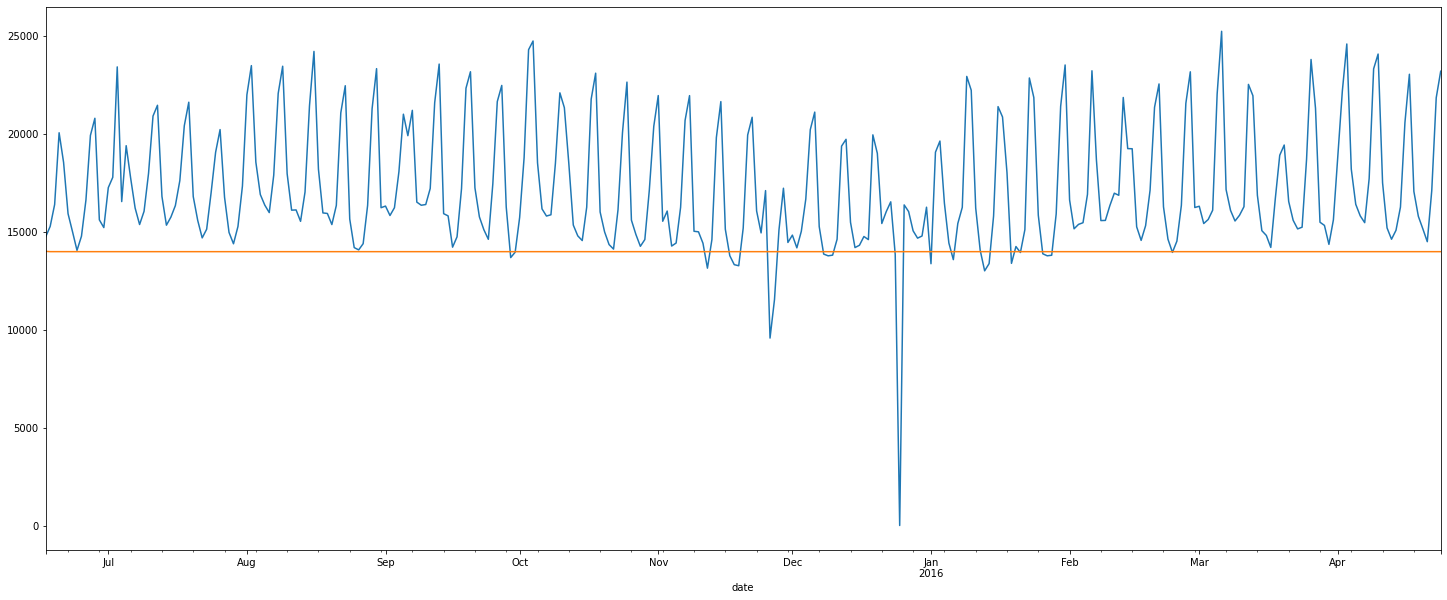

In [ ]:
cal.iloc[1600:].plot(figsize=(25,10))
predicted_result['California_pred'].plot()

##Sequential Deep Neural Network(LSTM and GRU)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional,Convolution1D
from keras.optimizers import SGD
import math
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

In [ ]:
training_set = data['sales'].iloc[:1600].values
test_set = data['sales'].iloc[1600:].values

In [ ]:
training_set=training_set.reshape(-1,1)

In [ ]:
sc = MinMaxScaler()
training_set_scaled = sc.fit_transform(training_set)

In [ ]:
X_train = []
y_train = []
for i in range(7,1600):
    X_train.append(training_set_scaled[i-7:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [ ]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)

In [ ]:
X_train.shape

(1586, 7, 1)

In [ ]:
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(Convolution1D(128, kernel_size=5,strides=1, activation='relu',input_shape=(X_train.shape[1],1)))
regressor.add(LSTM(units=100,activation='relu', return_sequences=True))
#input_shape=(X_train.shape[1],1)
#regressor.add(Dropout(0.2))
# Second LSTM layer
#regressor.add(GRU(units=100,activation='relu', return_sequences=True))
#regressor.add(Dropout(0.2))
# Third LSTM layer
#regressor.add(LSTM(units=50,activation='relu', return_sequences=True))
#regressor.add(Dropout(0.2))
# Fourth LSTM layer
regressor.add(LSTM(units=100,activation='relu'))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer=Adam(learning_rate=0.01),loss='mean_squared_error',metrics=['acc'])
filepath="weights.hdf4"
checkpointer = ModelCheckpoint(filepath=filepath,monitor = "loss", verbose=1, save_best_only=True)
# Fitting to the training set
regressor.fit(X_train,y_train,epochs=10,batch_size=32,callbacks=[checkpointer])

Epoch 1/10
1593/1593 [==============================] - 1s 920us/step - loss: 0.0921 - acc: 0.0000e+00

Epoch 00001: loss improved from inf to 0.09212, saving model to weights.hdf4
Epoch 2/10
1593/1593 [==============================] - 1s 548us/step - loss: 0.0181 - acc: 6.2775e-04

Epoch 00002: loss improved from 0.09212 to 0.01813, saving model to weights.hdf4
Epoch 3/10
1593/1593 [==============================] - 1s 538us/step - loss: 0.0148 - acc: 6.2775e-04

Epoch 00003: loss improved from 0.01813 to 0.01480, saving model to weights.hdf4
Epoch 4/10
1593/1593 [==============================] - 1s 535us/step - loss: 0.0103 - acc: 6.2775e-04

Epoch 00004: loss improved from 0.01480 to 0.01031, saving model to weights.hdf4
Epoch 5/10
1593/1593 [==============================] - 1s 518us/step - loss: 0.0103 - acc: 6.2775e-04

Epoch 00005: loss did not improve from 0.01031
Epoch 6/10
1593/1593 [==============================] - 1s 511us/step - loss: 0.0102 - acc: 6.2775e-04

Epoch 000

In [ ]:
inputs = data['sales'].iloc[1593:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

In [ ]:
X_test = []
for i in range(7,320):
    X_test.append(inputs[i-7:i,0])
X_test = np.array(X_test)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)
predicted_sales = regressor.predict(X_test)

In [ ]:
predicted_sales = sc.inverse_transform(predicted_sales)

In [ ]:
predicted_sales=pd.DataFrame(predicted_sales).rename(columns={0:"sales"})

In [ ]:
data['LSTM']=0
data['LSTM'].iloc[1600:]=predicted_sales['sales'].values

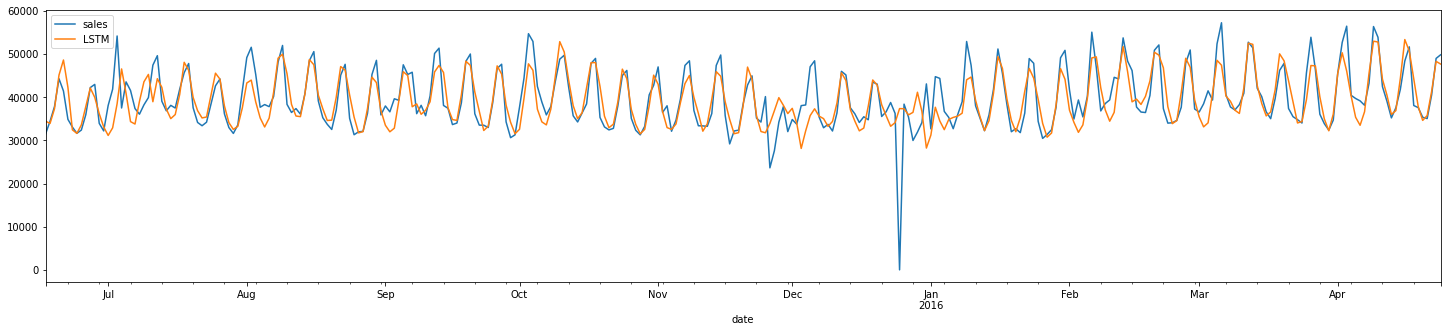

In [ ]:
data[['sales','LSTM']].iloc[1600:].plot(figsize=(25,5))

In [ ]:
rmse = math.sqrt(mean_squared_error(data['sales'].iloc[1600:].values, predicted_sales['sales'].values))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 4460.401114865996.


In [ ]:
predict = inputs[0:7,0].tolist()
pred_np = np.array(predict).reshape(1,-1,1)
predictions_final = []
for i in range(313):
    predicted_sales = regressor.predict(pred_np)
    predict.append(predicted_sales[0][0])
    predictions_final.append(predicted_sales[0][0])
    predict = predict[1:]
    pred_np = np.array(predict).reshape(1,7,1)

In [ ]:
predictions_final=np.array(predictions_final).reshape(-1,1)

In [ ]:
predictions_final = sc.inverse_transform(predictions_final)

In [ ]:
predictions_final=pd.DataFrame(predictions_final).rename(columns={0:"sales"})

In [ ]:
data['LSTM_pred']=0
data['LSTM_pred'].iloc[1600:]=predictions_final['sales'].values

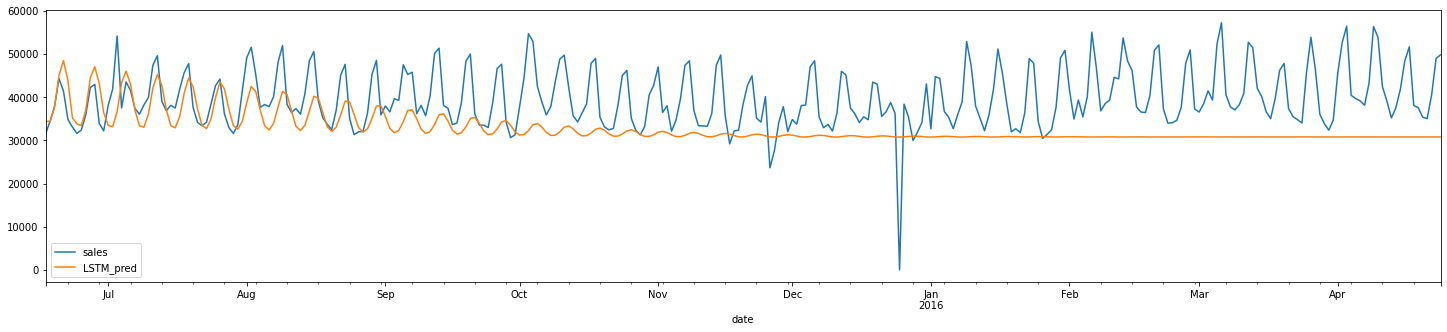

In [ ]:
data[['sales','LSTM_pred']].iloc[1600:].plot(figsize=(25,5))

In [ ]:
rmse = math.sqrt(mean_squared_error(data['sales'].iloc[1600:].values, predictions_final['sales'].values))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 9960.128928734423.


##Functional Deep Neural Network(LSTM and GRU)

In [ ]:
data1=data.copy()

In [ ]:
from pandas.tseries.offsets import DateOffset
add_dates=[data1.index[-1]+DateOffset(days=x) for x in range(0,30)]
future_dates=pd.DataFrame(index=add_dates[1:],columns=data1.columns)

In [ ]:
sales_data=pd.DataFrame()
store=['CA_1','CA_2','CA_3','CA_4','TX_1','TX_2','TX_3','WI_1','WI_2','WI_3']
dept=['FOODS_1','FOODS_2','FOODS_3','HOUSEHOLD_1','HOUSEHOLD_2','HOBBIES_1','HOBBIES_2']
for i in store:
  for j in dept:
    state_items = [c for c in past_sales.columns if i in c and j in c]
    sales_data[str(i)+'_'+str(j)] = past_sales[state_items].sum(axis=1)

In [ ]:
sales_data['day']=pd.DataFrame(sales_data.index.weekday).rename(columns={'date':'month'}).values
sales_data['month']=pd.DataFrame(sales_data.index.month).rename(columns={'date':'month'}).values

In [ ]:
sales_data.head()

CA_1_FOODS_1  CA_1_FOODS_2  ...  month  day
date                                    ...            
2011-01-29           297           674  ...      1    5
2011-01-30           284           655  ...      1    6
2011-01-31           214           396  ...      1    0
2011-02-01           175           476  ...      2    1
2011-02-02           182           354  ...      2    2

[5 rows x 72 columns]

In [ ]:
sales_data['CA_1_FOODS_1']

date
2011-01-29    297
2011-01-30    284
2011-01-31    214
2011-02-01    175
2011-02-02    182
             ... 
2016-04-20    287
2016-04-21    297
2016-04-22    331
2016-04-23    419
2016-04-24    329
Name: CA_1_FOODS_1, Length: 1913, dtype: int64

In [ ]:
batch_size = 32
train=sales_data['CA_1_FOODS_1'].iloc[:1600]
test=sales_data['CA_1_FOODS_1'].iloc[1600:]
generator=TimeseriesGenerator(
    train[21:], train[21:], length=7,batch_size=batch_size,
)

In [ ]:
generator2=TimeseriesGenerator(
    train, train, length=28,stride=1,sampling_rate=7,batch_size=batch_size
)

In [ ]:
monthday=[]
for i,j in zip(sales_data['month'],sales_data['day']):
  monthday.append((i,j))

In [ ]:
monthdaytemp = monthday[28:1600]
xtrain2 = []
for i in range(0,len(monthdaytemp),batch_size):
  xtrain2.append(monthdaytemp[i:i+batch_size])
len(xtrain2),len(generator),len(generator2)

(50, 50, 50)

In [ ]:
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers.recurrent import LSTM,GRU
from keras.layers.convolutional import Conv1D
from keras.layers.merge import concatenate
from keras.layers import Flatten
# first input model
visible1 = Input(shape=(7,1))
print(visible1.shape)
conv11 = Conv1D(128, kernel_size=3, activation='relu')(visible1)
conv12 = Conv1D(32, kernel_size=3, activation='relu')(conv11)
extract1 = LSTM(50, return_sequences=True,activation='relu')(conv12)
flat1 = Flatten()(extract1)
# second input model
visible2 = Input(shape=(4,1))
conv21 = Conv1D(64, kernel_size=2, activation='relu')(visible2)
conv22 = Conv1D(16, kernel_size=2, activation='relu')(conv21)
extract2 = LSTM(50, return_sequences=True,activation='relu')(conv22)
flat2 = Flatten()(extract2)
# third input model
visible3=Input(shape=(2,1))
flat3 = Flatten()(visible3)
# merge input models
merge = concatenate([flat1, flat2,flat3])
# interpretation model
hidden1 = Dense(128, activation='relu')(merge)
hidden2 = Dense(32, activation='relu')(hidden1)
output = Dense(1, activation='relu')(hidden2)
model = Model(inputs=[visible1, visible2,visible3], outputs=output)
# summarize layers
print(model.summary())

(None, 7, 1)
Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_28 (InputLayer)           (None, 7, 1)         0                                            
__________________________________________________________________________________________________
input_29 (InputLayer)           (None, 4, 1)         0                                            
__________________________________________________________________________________________________
conv1d_31 (Conv1D)              (None, 5, 128)       512         input_28[0][0]                   
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 3, 64)        192         input_29[0][0]                   
______________________________________________________________________________

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.01),loss='mean_squared_error',metrics=['mse'])
filepath="weights.hdf6"
checkpointer = ModelCheckpoint(filepath=filepath,monitor = "mse", verbose=1, save_best_only=True)

In [ ]:
epochs = 15
for i in range(epochs):
  for (x,y),(x2,y2),m in zip(generator,generator2,xtrain2):
    X=(np.expand_dims(x,axis = -1),np.expand_dims(x2,axis = -1),np.expand_dims(m,axis = -1))
    Y=y
    model.fit([X[0],X[1],X[2]],Y,epochs= 1, verbose = 0)
  mse = 0
  c = 0
  for (x,y),(x2,y2),m in zip(generator,generator2,xtrain2):
    X=(np.expand_dims(x,axis = -1),np.expand_dims(x2,axis = -1),np.expand_dims(m,axis = -1))
    Y=y
    mse += model.evaluate([X[0],X[1],X[2]],Y,verbose=0)[0]
    c+= 1
  print("MSE for epoch:" ,str(i), " is: ",mse/c)


MSE for epoch: 0  is:  4871.212218017578
MSE for epoch: 1  is:  4744.926101074218
MSE for epoch: 2  is:  4391.312836914062
MSE for epoch: 3  is:  4124.256297607422
MSE for epoch: 4  is:  3891.851837158203
MSE for epoch: 5  is:  3823.9448681640624
MSE for epoch: 6  is:  7113.617263183593
MSE for epoch: 7  is:  4581.761212158203
MSE for epoch: 8  is:  3811.5727990722658
MSE for epoch: 9  is:  3967.8759912109376
MSE for epoch: 10  is:  4039.468193359375
MSE for epoch: 11  is:  3859.8427612304686
MSE for epoch: 12  is:  4124.922150878906
MSE for epoch: 13  is:  4101.388784179688
MSE for epoch: 14  is:  4451.816398925781


In [ ]:
test=sales_data['CA_1_FOODS_1'].iloc[1572:]
generator_test=TimeseriesGenerator(
    test[21:], test[21:], length=7,batch_size=batch_size
)

In [ ]:
generator_test2=TimeseriesGenerator(
    test, test, length=28,stride=1,sampling_rate=7,batch_size=batch_size
)

In [ ]:
monthdaytest = monthday[1600:]
xtest2=[]
for i in range(0,len(monthdaytest),batch_size):
  xtest2.append(monthdaytest[i:i+batch_size])

In [ ]:
pred=[]
for (x,y),(x2,y2),m in zip(generator_test,generator_test2,xtest2):
    X=(np.expand_dims(x,axis = -1),np.expand_dims(x2,axis = -1),np.expand_dims(m,axis = -1))
    Y=y
    pred.append(model.predict([X[0],X[1],X[2]]))

In [ ]:
pred_act=[]
for i in pred:
  for j in i:
    pred_act.append(j)

In [ ]:
data_1

CA_1_FOODS_1
date                    
2011-01-29           297
2011-01-30           284
2011-01-31           214
2011-02-01           175
2011-02-02           182
...                  ...
2016-04-20           287
2016-04-21           297
2016-04-22           331
2016-04-23           419
2016-04-24           329

[1913 rows x 1 columns]

In [ ]:
data_1=pd.DataFrame(sales_data['CA_1_FOODS_1'].copy())

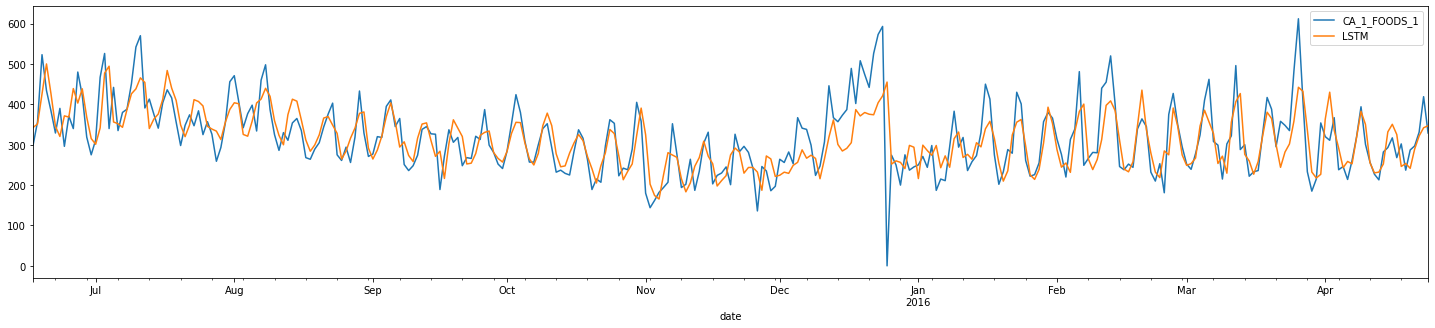

In [ ]:
data_1['LSTM']=0
data_1['LSTM'].iloc[1600:]=pred_act
data_1[['CA_1_FOODS_1','LSTM']].iloc[1600:].plot(figsize=(25,5))

In [ ]:
rmse = math.sqrt(mean_squared_error(data_1['CA_1_FOODS_1'].iloc[1600:].values, data_1['LSTM'].iloc[1600:].values))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 61.80031829145427.


In [ ]:
data1=sales_data[['month','day','CA_1_FOODS_1']].iloc[1572:1600].copy()

In [ ]:
from pandas.tseries.offsets import DateOffset
add_dates=[data1.index[-1]+DateOffset(days=x) for x in range(0,314)]
future_dates=pd.DataFrame(index=add_dates[1:],columns=data1.columns)

In [ ]:
future_dates['day']=pd.DataFrame(future_dates.index.weekday).rename(columns={'date':'month'}).values
future_dates['month']=pd.DataFrame(future_dates.index.month).rename(columns={'date':'month'}).values

In [ ]:
data2=pd.concat([data1,future_dates],axis=0)

In [ ]:
monthday1=[]
for i,j in zip(data2['month'],data2['day']):
  monthday1.append((i,j))

In [ ]:
for i in range(28,341,1):
  x=data2['CA_1_FOODS_1'].iloc[i-7:i].values
  x2=[data2['CA_1_FOODS_1'].iloc[i-28:i-27].values,data2['CA_1_FOODS_1'].iloc[i-21:i-20].values,data2['CA_1_FOODS_1'].iloc[i-14:i-13].values,data2['CA_1_FOODS_1'].iloc[i-7:i-6].values]
  m=monthday1[i]
  X=(np.expand_dims(x,axis = (0,-1)),np.expand_dims(x2,axis = (0)),np.expand_dims(m,axis = (0,-1)))
  data2['CA_1_FOODS_1'].iloc[i:i+1]=model.predict([X[0],X[1],X[2]])

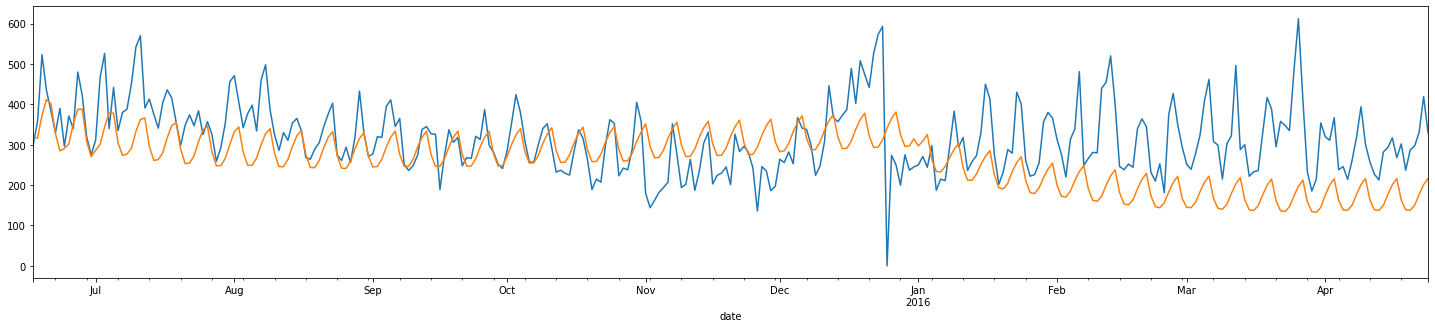

In [ ]:
sales_data['CA_1_FOODS_1'].iloc[1600:].plot(figsize=(25,5))
data2['CA_1_FOODS_1'].iloc[28:].plot(figsize=(25,5))

In [ ]:
rmse = math.sqrt(mean_squared_error(sales_data['CA_1_FOODS_1'].iloc[1600:].values, data2['CA_1_FOODS_1'].iloc[28:].values))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 108.29347353811272.


## Utility functions

In [ ]:
#Get one hot for 6 columns and concat it before all those sales 

In [ ]:
sales

id        item_id  ... d_1912 d_1913
0      HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  ...      1      1
1      HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  ...      0      0
2      HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  ...      1      1
3      HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  ...      7      2
4      HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  ...      2      4
...                              ...            ...  ...    ...    ...
30485    FOODS_3_823_WI_3_validation    FOODS_3_823  ...      0      1
30486    FOODS_3_824_WI_3_validation    FOODS_3_824  ...      1      0
30487    FOODS_3_825_WI_3_validation    FOODS_3_825  ...      1      0
30488    FOODS_3_826_WI_3_validation    FOODS_3_826  ...      1      3
30489    FOODS_3_827_WI_3_validation    FOODS_3_827  ...      0      0

[30490 rows x 1919 columns]

In [ ]:
d_cols = [c for c in sales.columns if 'd_' in c]

In [ ]:
past_sales = sales.set_index('id')[d_cols].T.merge(calendar.set_index('d')['date'],
           left_index=True,
           right_index=True,
           validate='1:1').set_index('date')

In [ ]:
import pandas as pd

calender = pd.read_csv("calendar.csv")

calender.head()

date  wm_yr_wk    weekday  ...  snap_CA  snap_TX  snap_WI
0  2011-01-29     11101   Saturday  ...        0        0        0
1  2011-01-30     11101     Sunday  ...        0        0        0
2  2011-01-31     11101     Monday  ...        0        0        0
3  2011-02-01     11101    Tuesday  ...        1        1        0
4  2011-02-02     11101  Wednesday  ...        1        0        1

[5 rows x 14 columns]

In [ ]:
!mkdir drive/My\ Drive/m5forecast

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
a = []
while(1):
  a.append('1')

In [ ]:
import pandas as pd
import os

sales = pd.read_csv('sales_train_validation.csv')

for i in range(sales.shape[0]):
    #training
    if os.path.exists(str(i) + "_val.csv"):
      #print("found ",i)
      continue
    x,z = sales[sales.columns[6:1606]].iloc[i],sales[sales.columns[1:6]].iloc[i].copy()
    x = pd.DataFrame({"sales_i":x.values,"d":x.index.values})
    
    #val
    v = sales[sales.columns[1606:]].iloc[i].copy()
    v = pd.DataFrame({"sales_i":v.values,"d":v.index.values})
    
    for p in z.index:
      x[p] = z[p]
      v[p] = z[p]

    #x.to_csv("drive/My Drive/m5forecast/" + str(i) + "_train.csv",index=False)
    #v.to_csv("drive/My Drive/m5forecast/" + str(i) + "_val.csv",index=False)
    x.to_csv(str(i) + "_train.csv",index=False)
    v.to_csv(str(i) + "_val.csv",index=False)

In [ ]:
!cp *_train.csv drive/My\ Drive/m5forecast
!cp *_val.csv drive/My\ Drive/m5forecast

In [ ]:
import pandas as pd
prices = pd.read_csv("sell_prices.csv")
calender= pd.read_csv("calendar.csv")
# sales= pd.read_csv("sales_train_validation.csv")

In [ ]:
all_cal_cols = ['date', 'wday', 'month', 'd',"wm_yr_wk",
       'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
       'snap_CA', 'snap_TX', 'snap_WI']

In [ ]:
calender_prices=calender[all_cal_cols].merge(prices[['wm_yr_wk',"sell_price",'item_id','store_id']],on = "wm_yr_wk")

In [ ]:
del prices
del calender
calender_prices.shape


(47735397, 15)

In [ ]:
# prices = pd.read_csv("sell_prices.csv")

import dask
from 
# prices["yr"] = prices["wm_yr_wk"]//100 + 1900
# calender.merge(prices[['wm_yr_wk',"price"]],on = "wm_yr_wk")

In [ ]:
calender_prices.columns

Index(['date', 'wm_yr_wk', 'weekday', 'wday', 'month', 'year', 'd',
       'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
       'snap_CA', 'snap_TX', 'snap_WI', 'sell_price', 'item_id', 'store_id'],
      dtype='object')

In [ ]:
l=[]
while True:
  l.append("!!!!!!"*100000000)

In [ ]:
catcalprice = ['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
calender_prices[catcalprice].fillna("nothing",inplace =True)



# getcats(catcalprice,calender_prices)

In [ ]:
le_catcalprice = {i:preprocessing.LabelEncoder() for i in catcalprice}
for k in le_catcalprice.keys():
  le_catcalprice[k].fit(calender_prices[k])


In [ ]:
for le_k in le_catcalprice.keys():
  calender_prices[le_k] = le_catcalprice[le_k].transform(calender_prices[le_k].fillna("nothing"))
calender_prices.head()

In [ ]:
from sklearn import preprocessing
def getcats(col_names,df):
  le = {i:preprocessing.LabelEncoder() for i in col_names}
  for k in le.keys():
    le[k].fit(df[k])
  return le

In [ ]:
from sklearn import preprocessing
import glob
s= 0

#in sales...['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']
sales_cats = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']
calender_cats = ['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']


##These are columns you want from calendar as it is
cal_numerical = ['wday', 'month','snap_CA', 'snap_TX', 'snap_WI']

#sale cats to nums
le = getcats(sales_cats,sales)

#calender_cats to nums
cal_le = getcats(calender_cats,calender)


for i in glob.glob("*_train.csv"):
  c = pd.read_csv(i)
  #this makes everyhing numeric
  for k in le.keys():
    c[k] = le[k].transform(c[k])
  # now we need month, date, event type and event 
  
  break
  if s==0:
    finaltrain = c
  else:
    finaltrain = pd.concat((c,finaltrain))

In [ ]:
calender = pd.read_csv("calendar.csv")
calender["event_type_1"	].value_counts()



Religious    55
National     52
Cultural     37
Sporting     18
Name: event_type_1, dtype: int64

In [ ]:
c.head()

sales_i    d      item_id  dept_id cat_id store_id state_id
0        0  d_1  FOODS_3_389  FOODS_3  FOODS     WI_1       WI
1        0  d_2  FOODS_3_389  FOODS_3  FOODS     WI_1       WI
2        0  d_3  FOODS_3_389  FOODS_3  FOODS     WI_1       WI
3        0  d_4  FOODS_3_389  FOODS_3  FOODS     WI_1       WI
4        0  d_5  FOODS_3_389  FOODS_3  FOODS     WI_1       WI

array(['FOODS_1_001', 'FOODS_1_002', 'FOODS_1_003', ...,
       'HOUSEHOLD_2_514', 'HOUSEHOLD_2_515', 'HOUSEHOLD_2_516'],
      dtype=object)

In [ ]:
s.head()

d_1  d_2  d_3  ...  d_1911  d_1912  d_1913
id                                            ...                        
HOBBIES_1_001_CA_1_validation    0    0    0  ...       0       1       1
HOBBIES_1_002_CA_1_validation    0    0    0  ...       0       0       0
HOBBIES_1_003_CA_1_validation    0    0    0  ...       1       1       1
HOBBIES_1_004_CA_1_validation    0    0    0  ...       3       7       2
HOBBIES_1_005_CA_1_validation    0    0    0  ...       2       2       4
...                            ...  ...  ...  ...     ...     ...     ...
FOODS_3_823_WI_3_validation      0    0    2  ...       0       0       1
FOODS_3_824_WI_3_validation      0    0    0  ...       0       1       0
FOODS_3_825_WI_3_validation      0    6    0  ...       0       1       0
FOODS_3_826_WI_3_validation      0    0    0  ...       3       1       3
FOODS_3_827_WI_3_validation      0    0    0  ...       0       0       0

[30490 rows x 1913 columns]